In [7]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.multitest import fdrcorrection
from sklearn.cluster import KMeans

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

gene_names = sc.queries.biomart_annotations('hsapiens', attrs=['ensembl_gene_id', 'hgnc_symbol'], use_cache=True)
adata = sc.datasets.ebi_expression_atlas('E-MTAB-9221')
adata.var = adata.var.join(gene_names[gene_names.ensembl_gene_id.isin(adata.var_names)
                                     ].drop_duplicates('ensembl_gene_id').set_index('ensembl_gene_id'))
adata.var.hgnc_symbol.fillna(pd.Series(adata.var.index.values, index=adata.var.index), inplace=True)
adata.var['ensembl_gene_id'] = adata.var_names
adata.var.set_index('hgnc_symbol', inplace=True)
adata.var_names = adata.var.index
adata.var_names_make_unique()

cell_marker = pd.read_csv('~/Downloads/CellMarker.csv')
cell_marker2 = pd.read_csv('~/Downloads/CellMarker.Experiment.csv')
cell_marker = pd.concat([cell_marker, cell_marker2])
cell_marker = cell_marker[cell_marker.Cancer == 'Normal']

adata.obs['COVID'] = 1 - pd.get_dummies(adata.obs['Factor Value[clinical history]'])['control']

for c in adata.obs.columns:
    if 2 < adata.obs[c].nunique() < 100:
        print(c, adata.obs[c].unique())

Sample Characteristic[sex] ['female', 'male', 'not available']
Categories (3, object): ['female', 'male', 'not available']
Sample Characteristic Ontology Term[sex] ['http://purl.obolibrary.org/obo/PATO_0000383', 'http://purl.obolibrary.org/obo/PATO_0000384', 'nan']
Categories (3, object): ['http://purl.obolibrary.org/obo/PATO_0000383', 'http://purl.obolibrary.org/obo/PATO_0000384', 'nan']
Sample Characteristic[age] ['54 year', '27 year', '58 year', '21 year', '69 year', '26 year', 'not available']
Categories (7, object): ['54 year', '27 year', '58 year', '21 year', '69 year', '26 year', 'not available']
Sample Characteristic[individual] ['Control #1', 'Control #2', 'Control #3', 'SARS-CoV2 pos Mild', 'SARS-CoV2 pos Severe #1', 'SARS-CoV2 pos Severe #2', 'SARS-CoV2 pos Severe #3']
Categories (7, object): ['Control #1', 'Control #2', 'Control #3', 'SARS-CoV2 pos Mild', 'SARS-CoV2 pos Severe #1', 'SARS-CoV2 pos Severe #2', 'SARS-CoV2 pos Severe #3']
Sample Characteristic[clinical history]

In [8]:
def find_grouped_counts(adata, f=10):
    data = adata.copy()
    sc.pp.normalize_total(data, target_sum=1e3)
    sc.pp.log1p(data)
    sc.tl.pca(data, svd_solver='arpack')
    sc.pp.neighbors(data, n_neighbors=250, n_pcs=50)
    sc.tl.leiden(data, resolution=1)
    sc.pp.calculate_qc_metrics(data, inplace=True)
    to_drop = data.obs.total_counts > data.obs.groupby('leiden').total_counts.transform(lambda x: np.percentile(x, f))
    return to_drop

def compute_scores(adata, cell_marker=cell_marker):
    score_cols = []
    marker_grp = cell_marker[~cell_marker['Cell Type'].str.lower()\
                                                        .str.contains('cancer')
                            ].groupby('Cell Type')
    for cell, g in marker_grp:
        gene_list = [] 
        for glist in g['Cell Marker'].tolist():
            gene_list += [g.strip() for g in glist.split(',')]

        gene_list = list(set(gene_list))
        length = (len(gene_list) - np.sum([gene not in adata.raw.var_names for gene in gene_list]) < 3)
        if (length &
            (cell != 'Platelet')):
            continue

        score_cols += [cell]
        sc.tl.score_genes(adata, gene_list, score_name=cell + '_score', use_raw=True)
        
def kmeans_assign(adata):
    score_cols = [c for c in adata.obs.columns if '_score' in c]
    
    km = KMeans(len(score_cols))
    adata.obs['log_total_counts'] = adata.obs.total_counts.apply(np.log10)
    labels = km.fit_predict(adata.obs[score_cols + ['log_total_counts']])
    adata.obs['KMLabel'] = labels
    adata.obs.KMLabel = adata.obs.KMLabel.astype('category')
    label_names = adata.obs.groupby('KMLabel')[score_cols].agg(np.median).idxmax(axis=1).to_dict()
    
    adata.obs['PredictedLabel'] = adata.obs.KMLabel.map(label_names)

In [9]:
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=10)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts.between(0, 7000), :]
adata = adata[adata.obs.pct_counts_mt.between(2, 20), :]

# split data into high and low count cells
h_adata = adata[adata.obs.total_counts > 10 ** 3.5]
l_adata = adata[adata.obs.total_counts.between(500, 10 ** 3.5)]

h_adata = h_adata[find_grouped_counts(h_adata, f=5)]
l_adata = l_adata[find_grouped_counts(l_adata, f=10)]

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


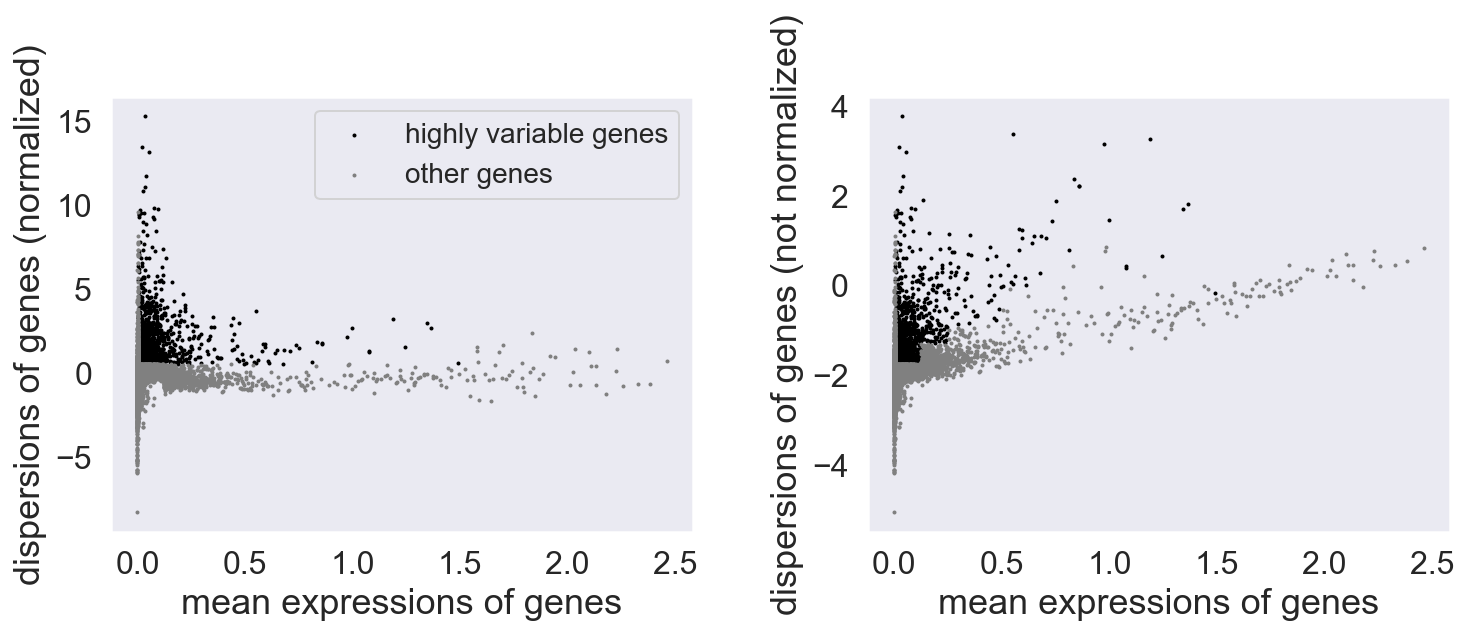

Trying to set attribute `.obs` of view, copying.


In [10]:
sc.pp.normalize_total(h_adata, target_sum=1e3)
sc.pp.log1p(h_adata)
sc.pp.highly_variable_genes(h_adata, min_mean=0.005, max_mean=1.5, min_disp=0.5)
sc.pl.highly_variable_genes(h_adata)
h_adata.raw = h_adatai
h_adata = h_adata[:, h_adata.var.highly_variable]

compute_scores(h_adata, cell_marker[cell_marker['Cell Type'] != 'Platelet'])
kmeans_assign(h_adata)

... storing 'PredictedLabel' as categorical


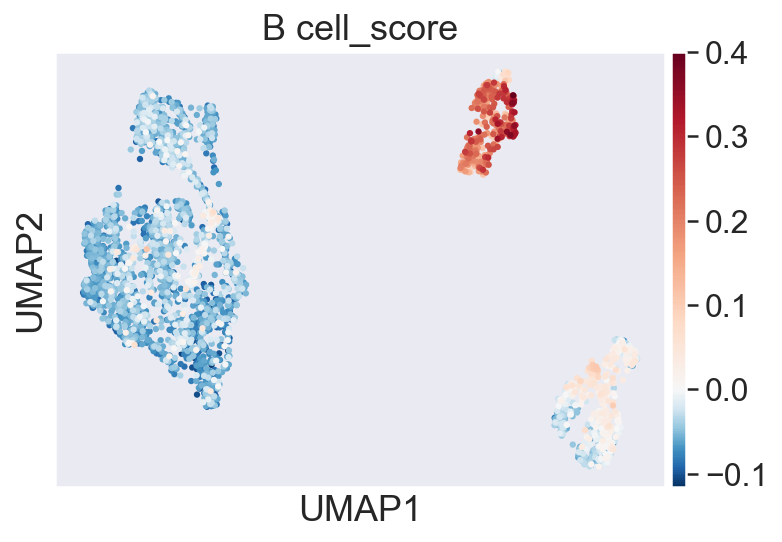

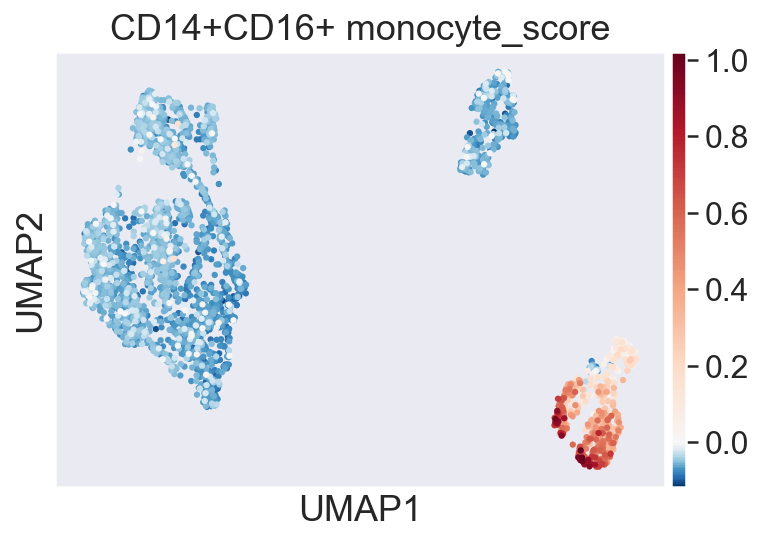

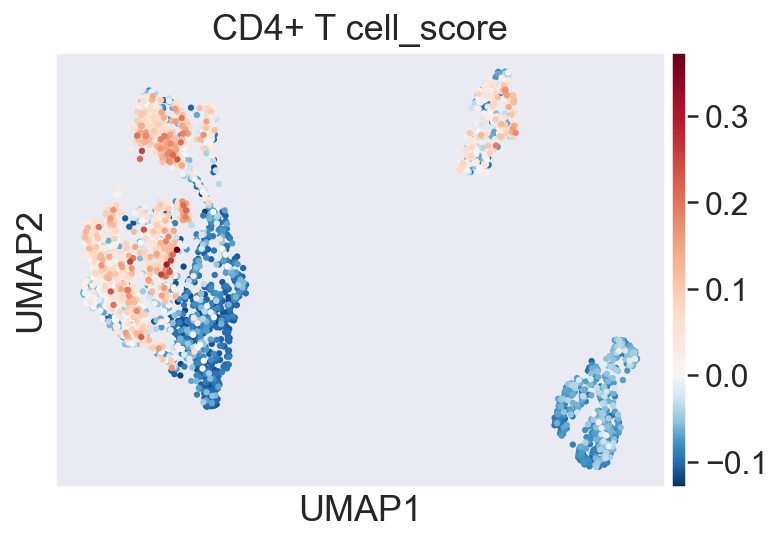

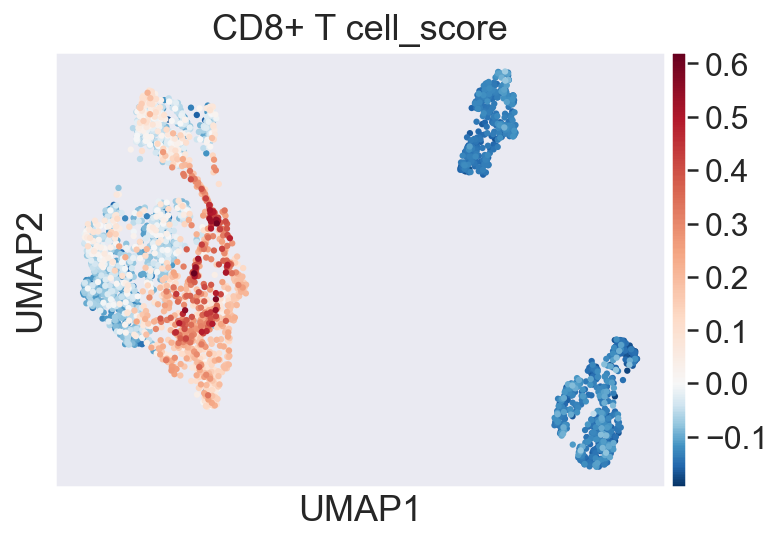

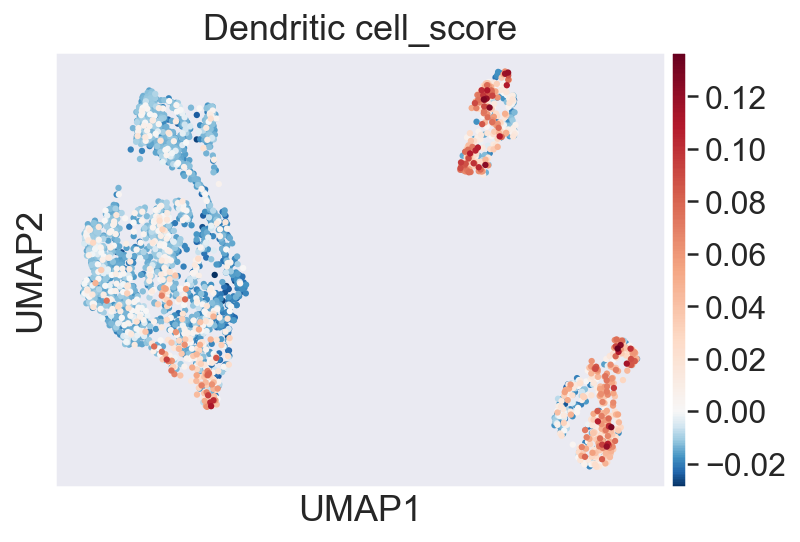

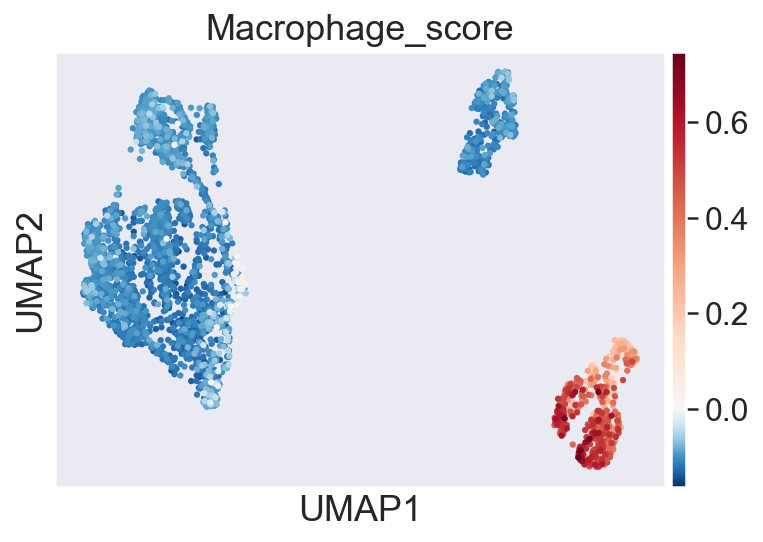

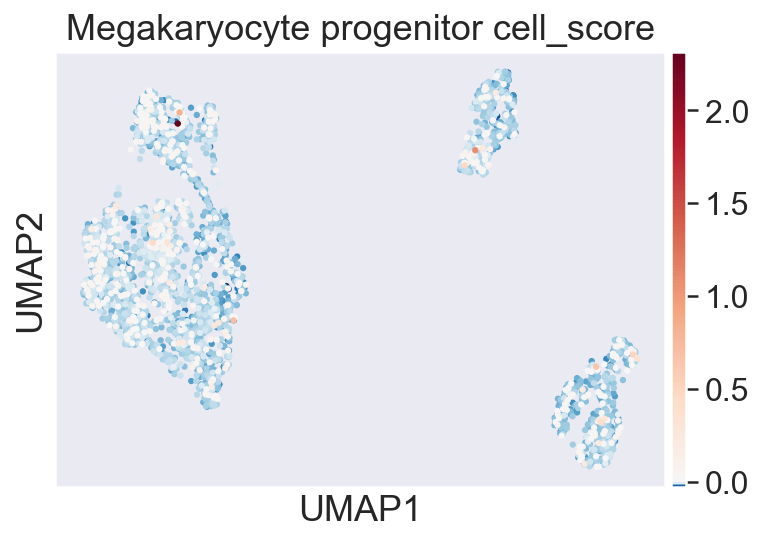

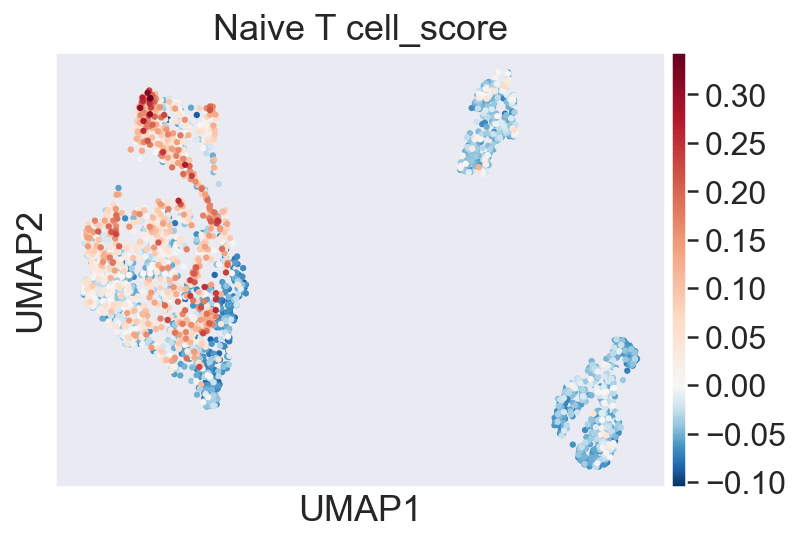

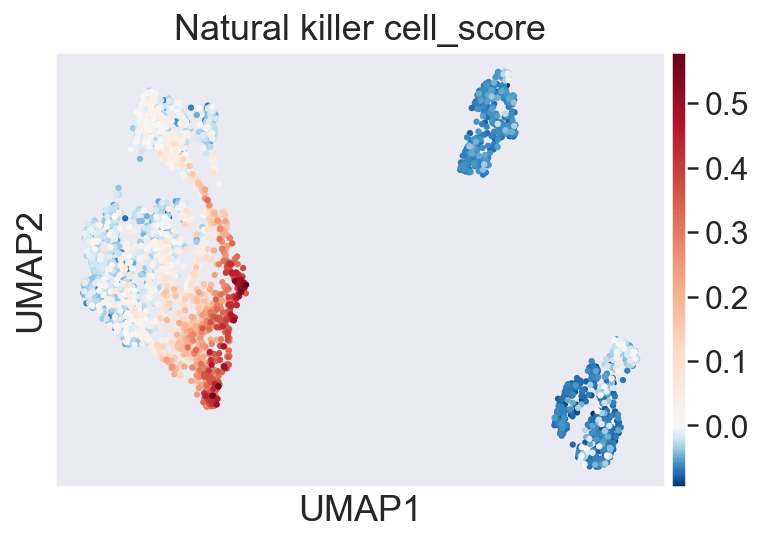

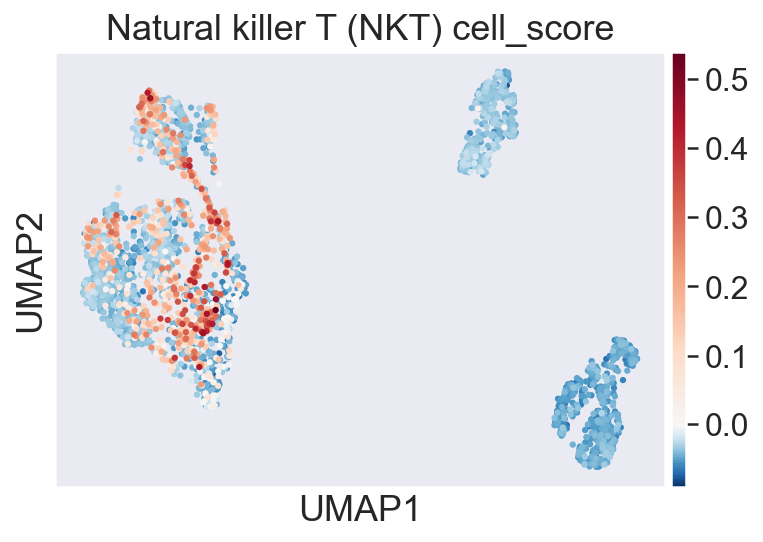

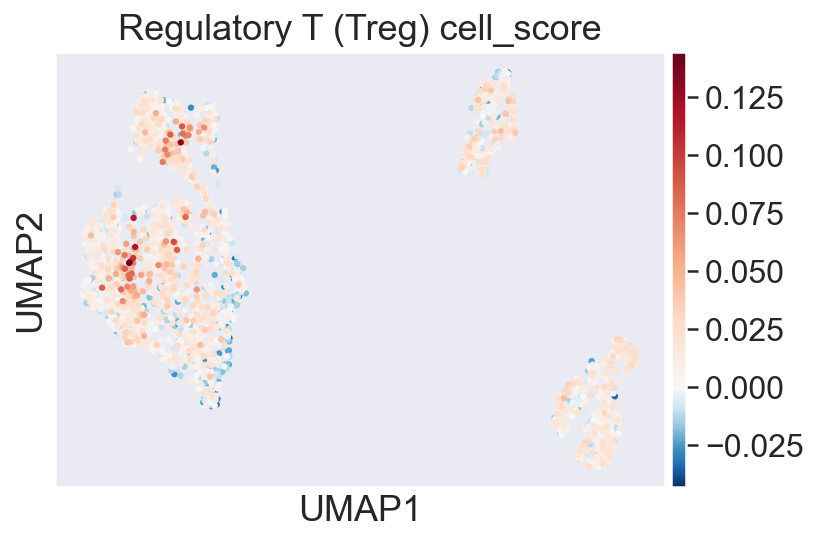

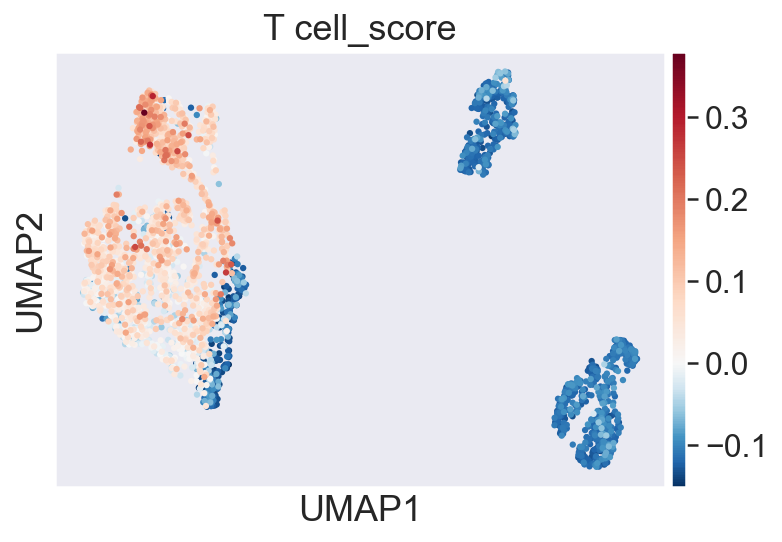

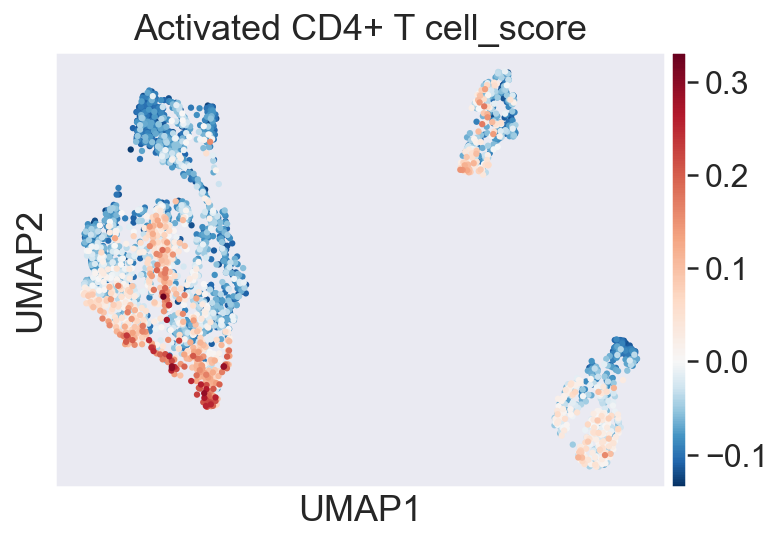

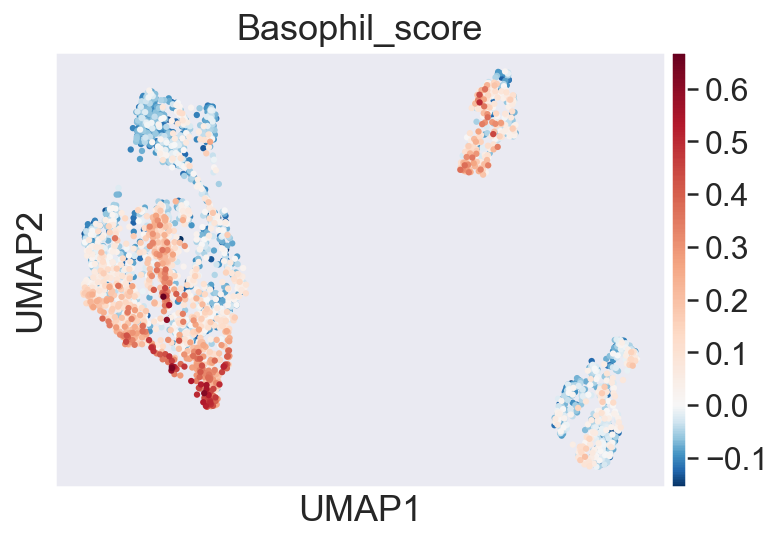

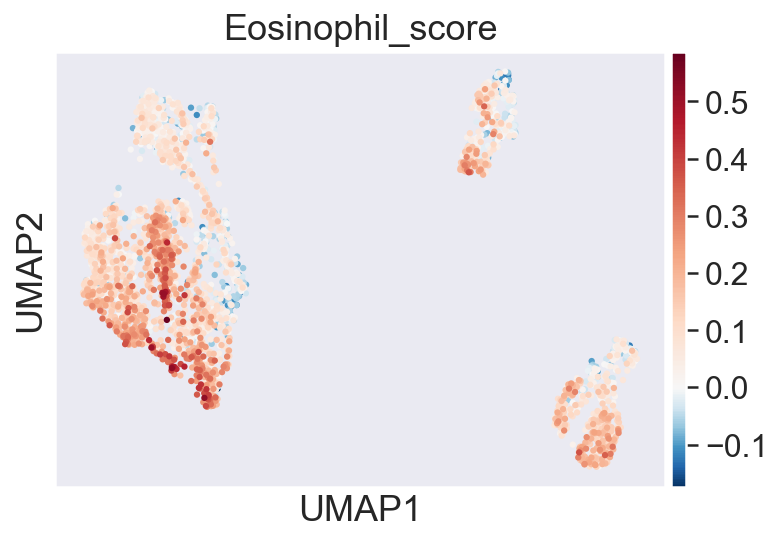

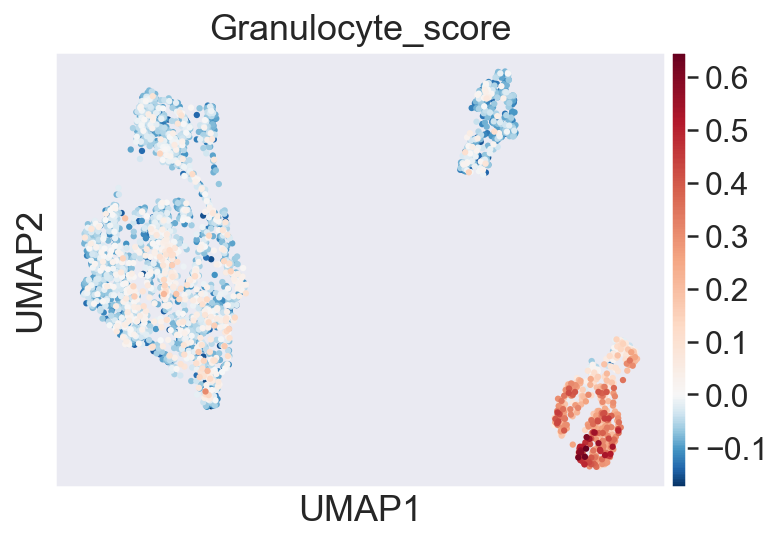

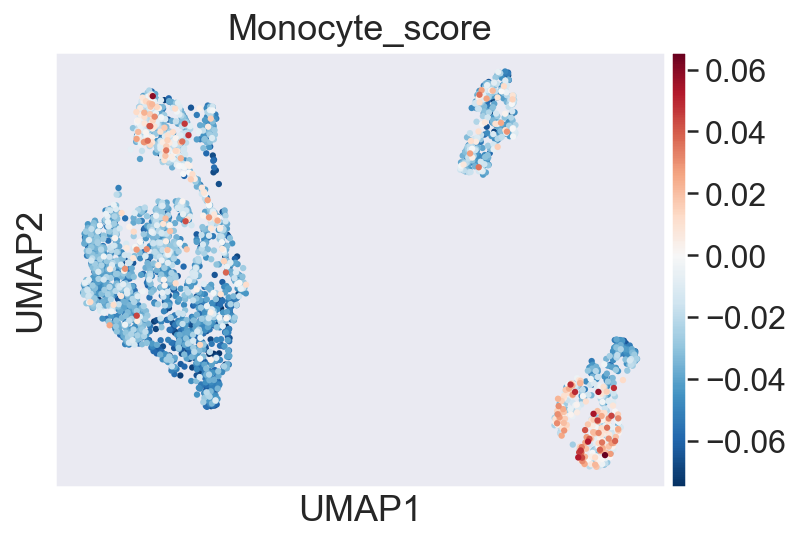

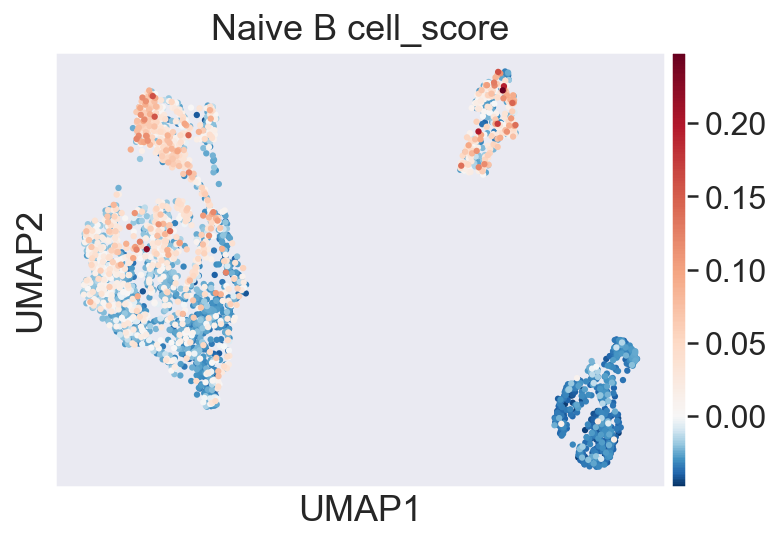

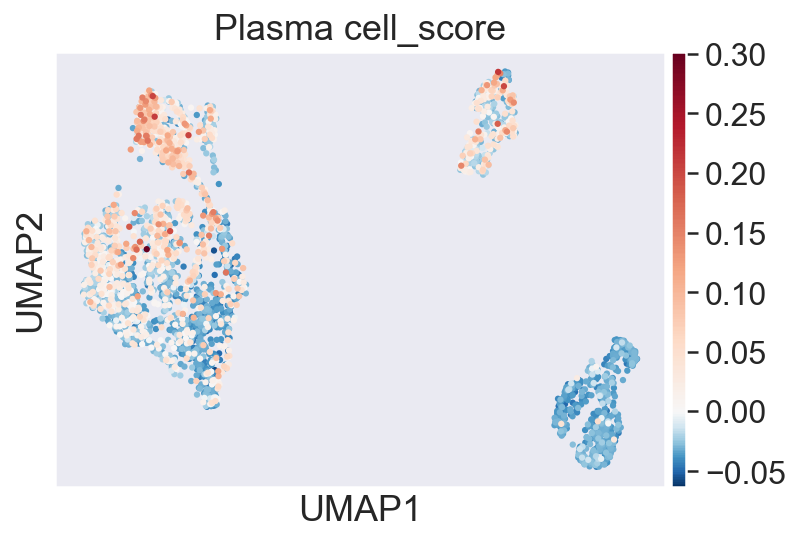

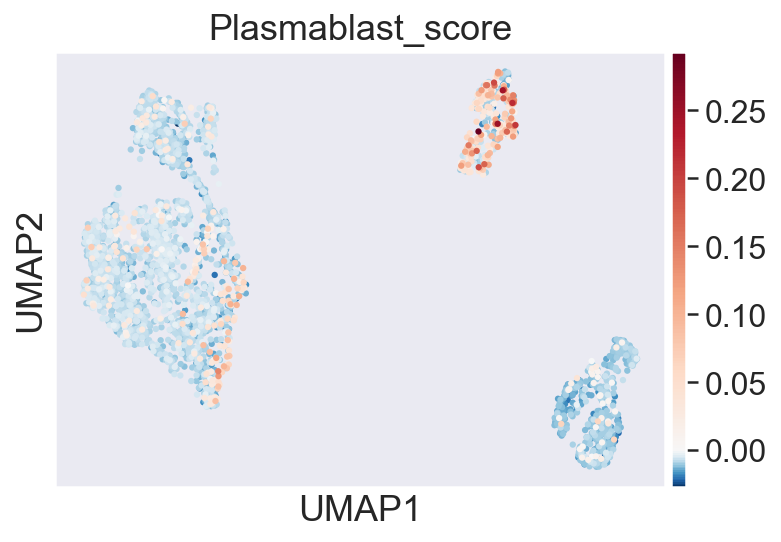

In [11]:
sc.tl.pca(h_adata, svd_solver='arpack')
sc.pp.neighbors(h_adata, n_neighbors=75, n_pcs=50)
sc.tl.leiden(h_adata, resolution=1)
sc.tl.umap(h_adata)#, init_pos='paga')

for cell in cell_marker['Cell Type'].unique():
    if cell + '_score' not in h_adata.obs.columns:
        continue
    sc.pl.umap(h_adata, color=cell + '_score', cmap='RdBu_r', vcenter=0)

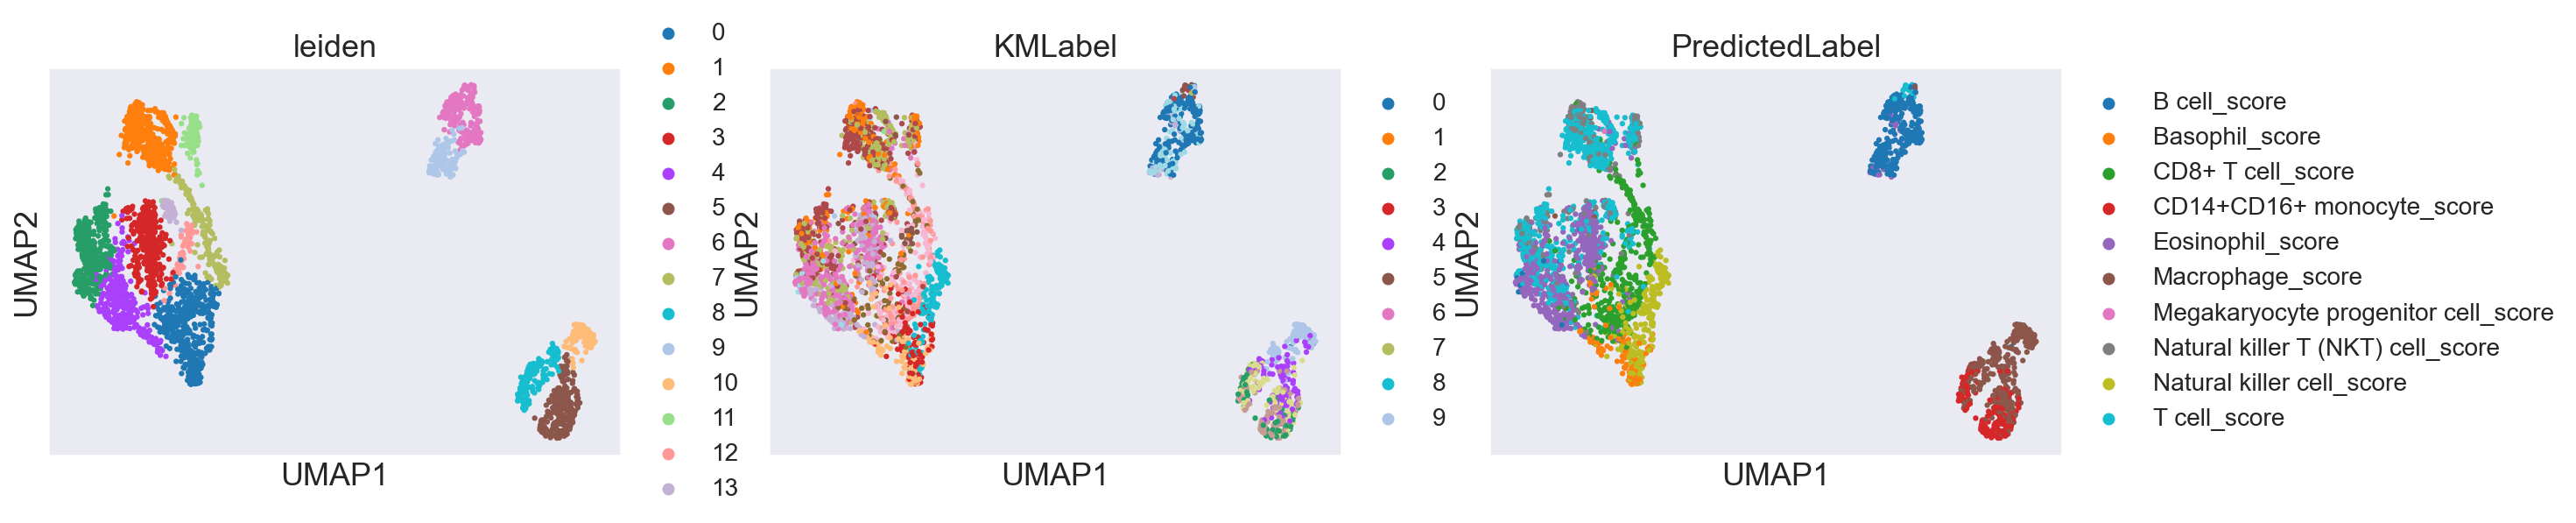

In [12]:
sc.pl.umap(h_adata, color=['leiden', 'KMLabel', 'PredictedLabel'])

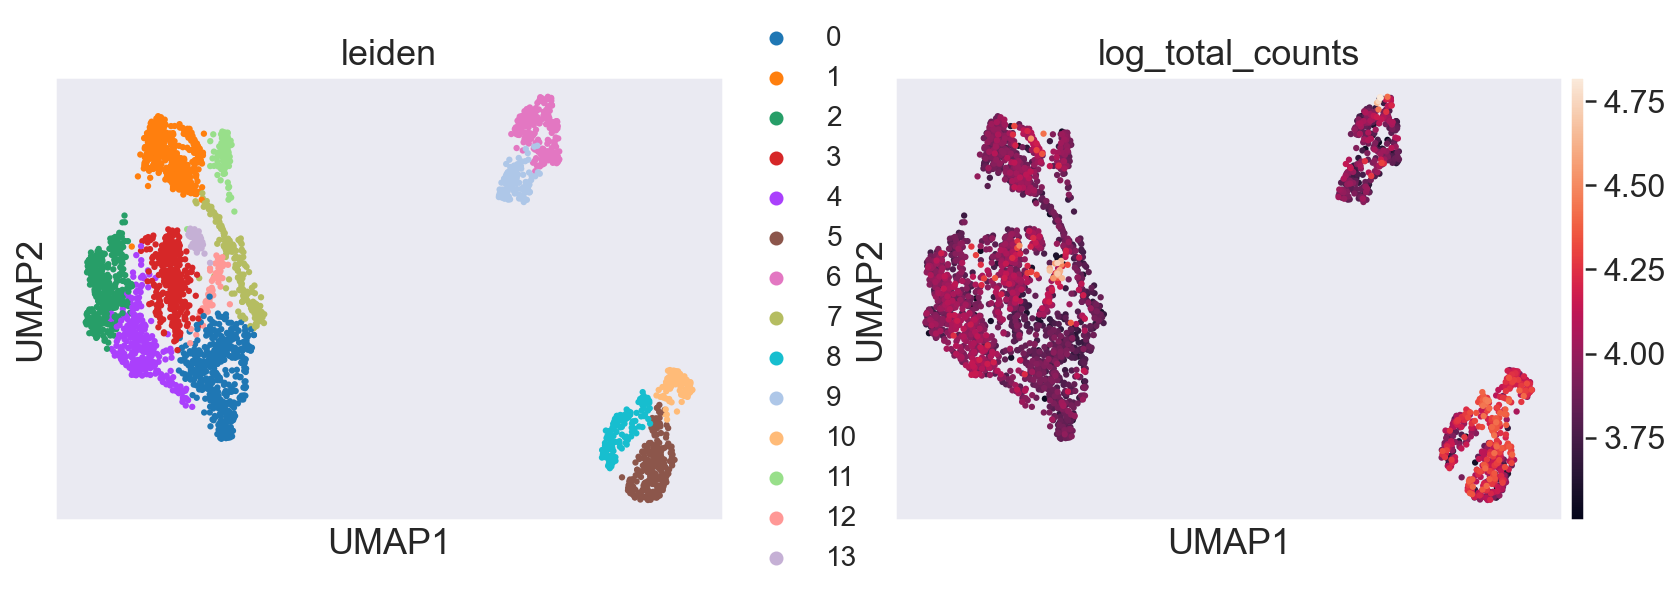

In [13]:
h_adata.obs['log_total_counts'] = h_adata.obs.total_counts.apply(np.log10)
sc.pl.umap(h_adata, color=['leiden', 'log_total_counts'])

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


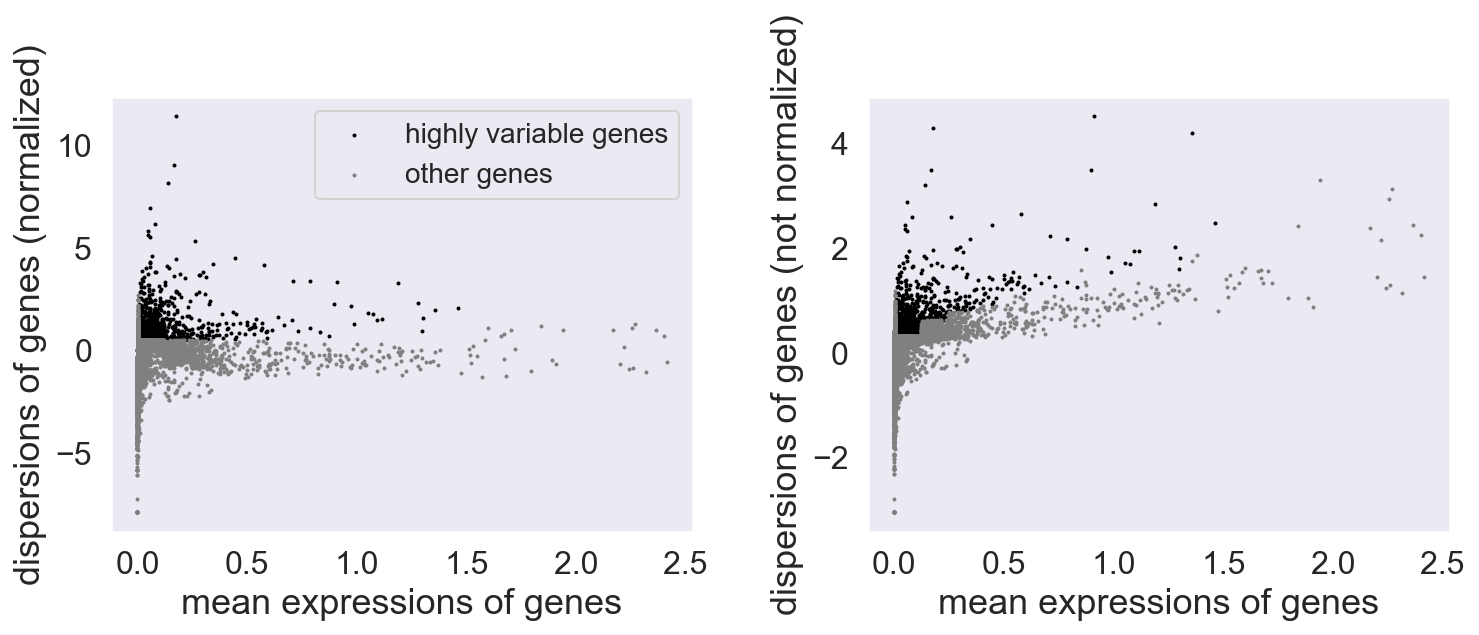

Trying to set attribute `.obs` of view, copying.


In [14]:
sc.pp.normalize_total(l_adata, target_sum=1e3)
sc.pp.log1p(l_adata)
sc.pp.highly_variable_genes(l_adata, min_mean=0.005, max_mean=1.5, min_disp=0.5)
sc.pl.highly_variable_genes(l_adata)
l_adata.raw = l_adata
l_adata = l_adata[:, l_adata.var.highly_variable]

compute_scores(l_adata)
kmeans_assign(l_adata)

sc.tl.pca(l_adata, svd_solver='arpack')
sc.pp.neighbors(l_adata, n_neighbors=75, n_pcs=50)
sc.tl.leiden(l_adata, resolution=1)
sc.tl.umap(l_adata)#, init_pos='paga')

... storing 'PredictedLabel' as categorical


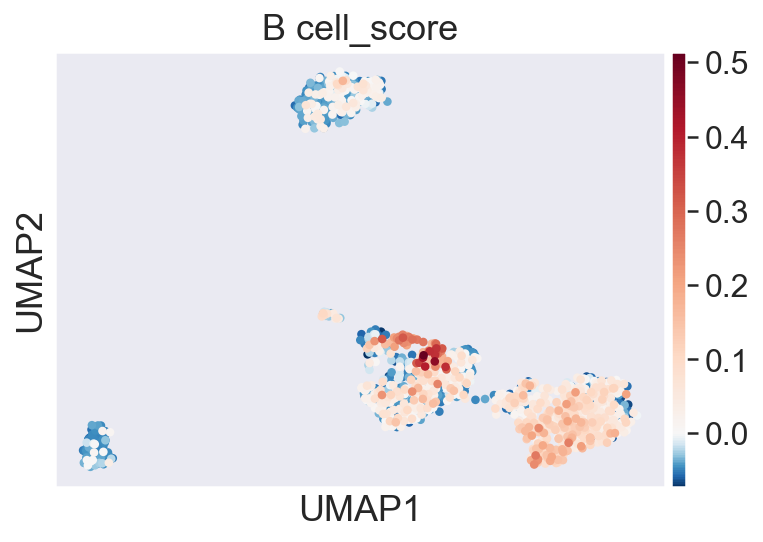

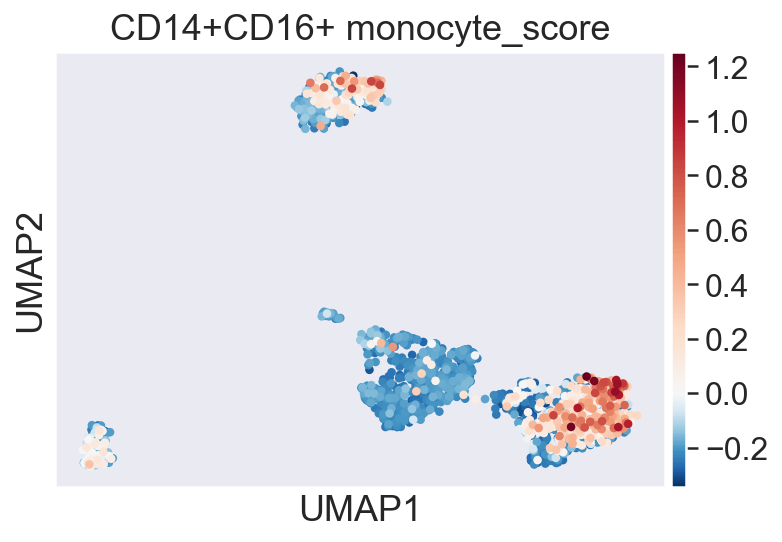

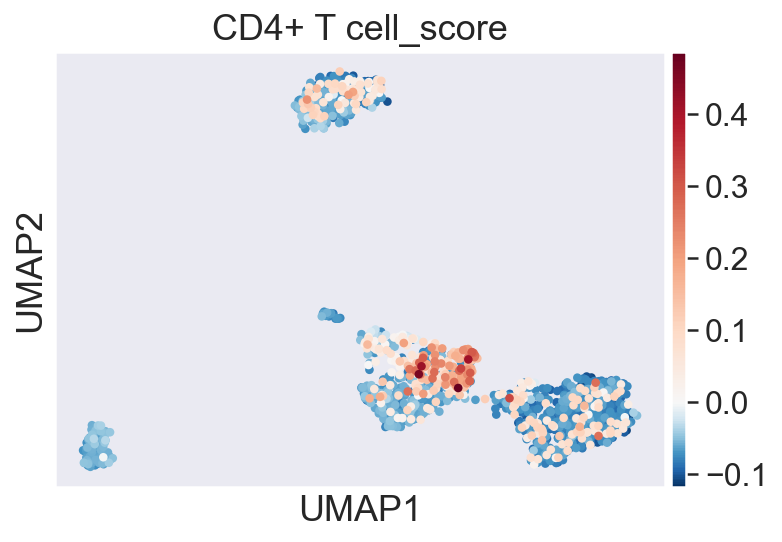

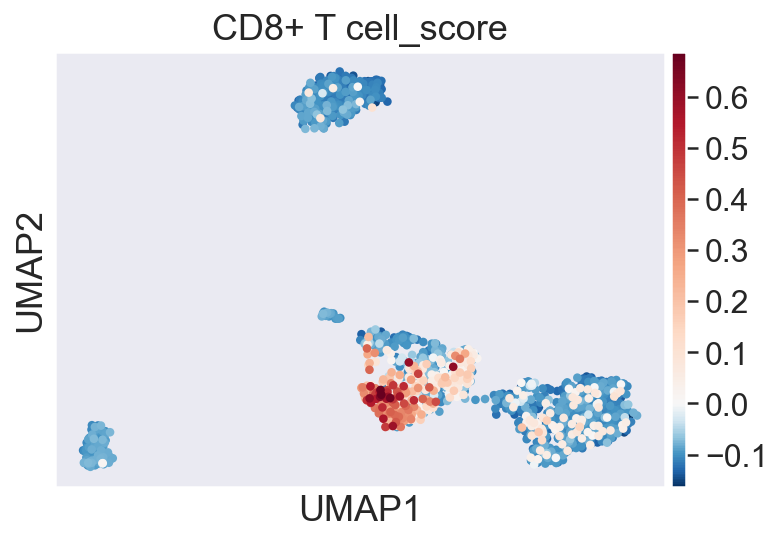

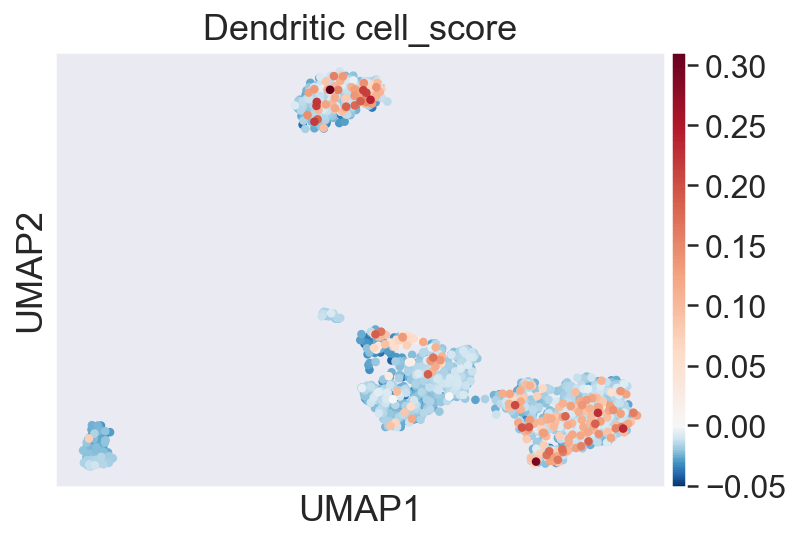

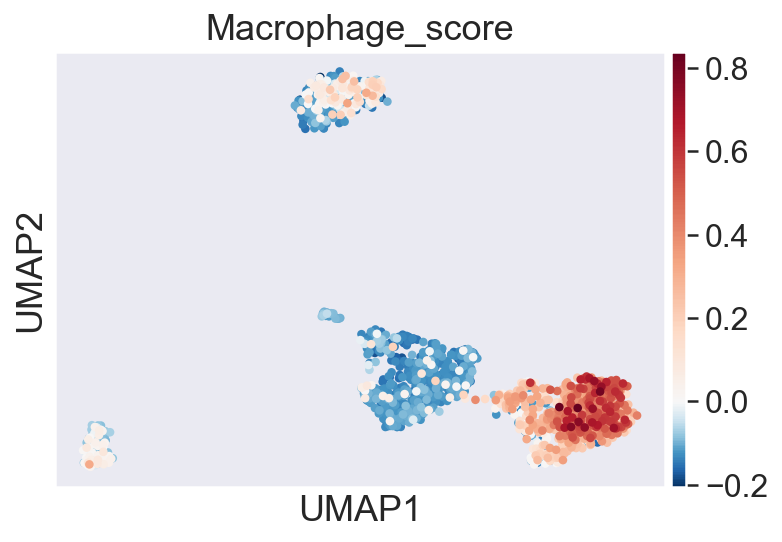

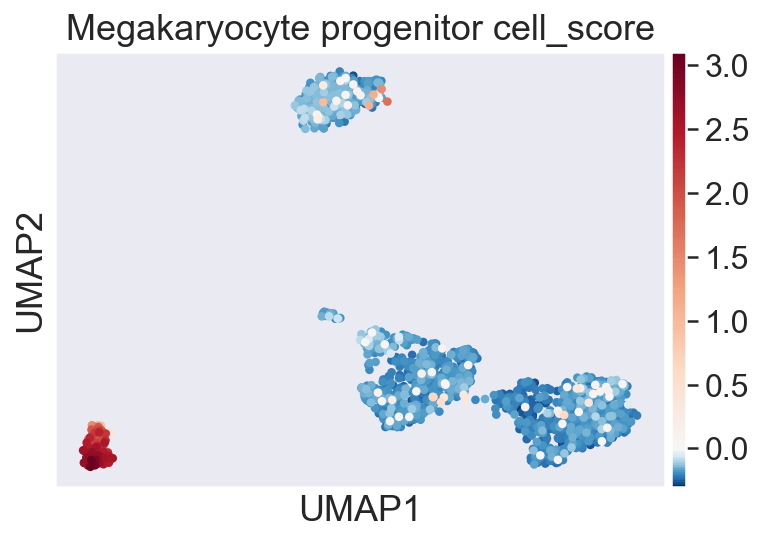

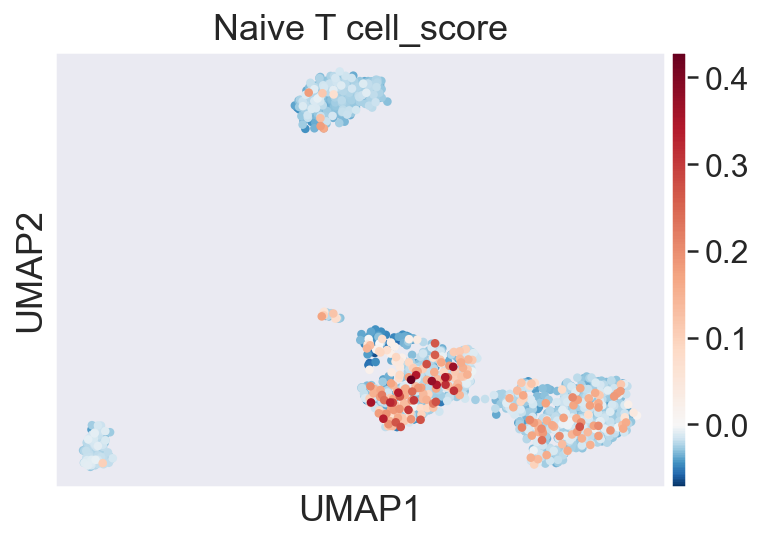

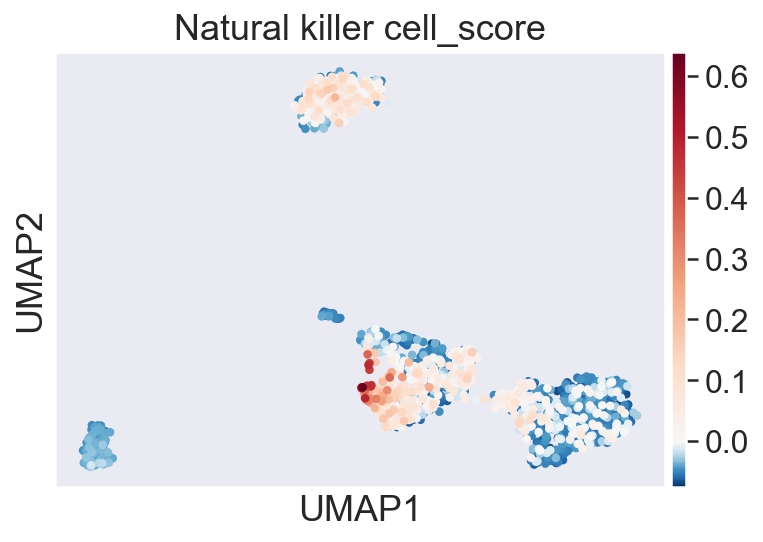

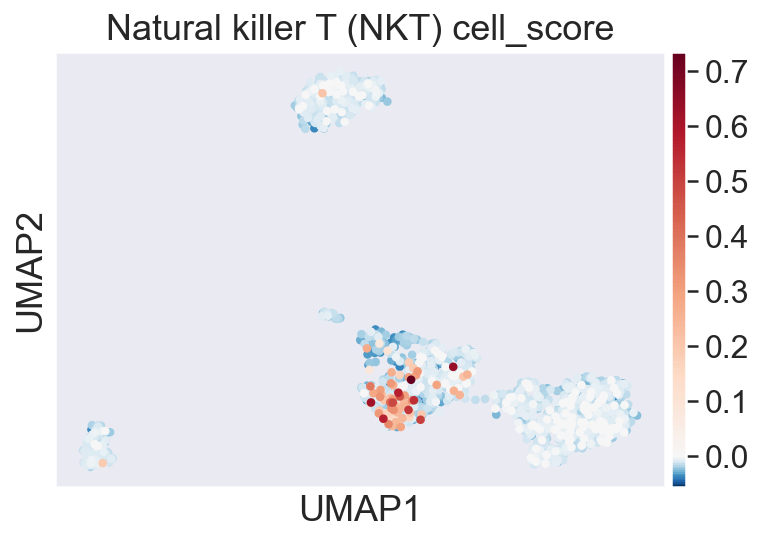

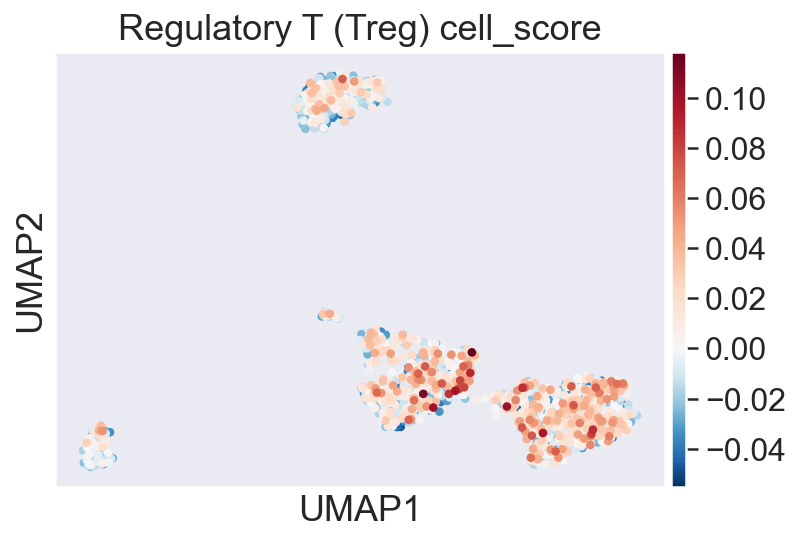

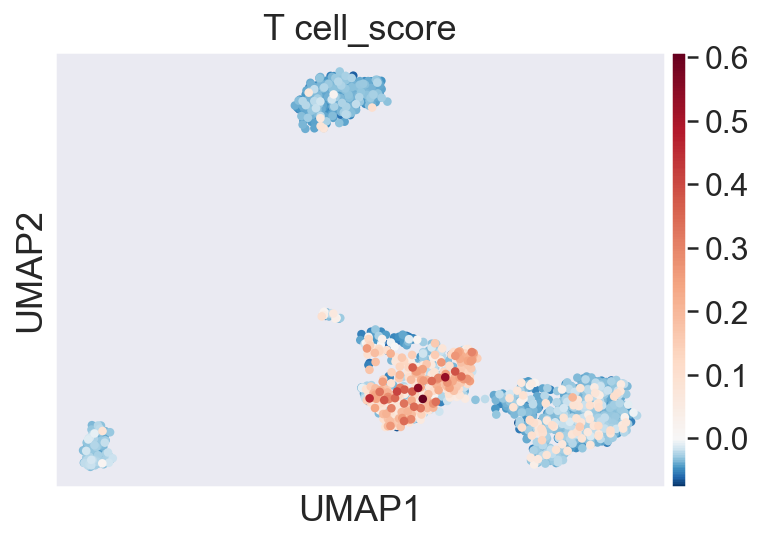

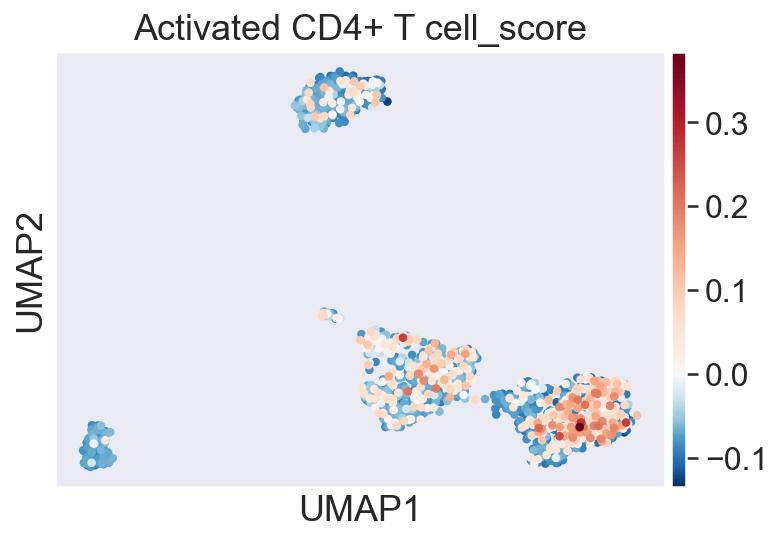

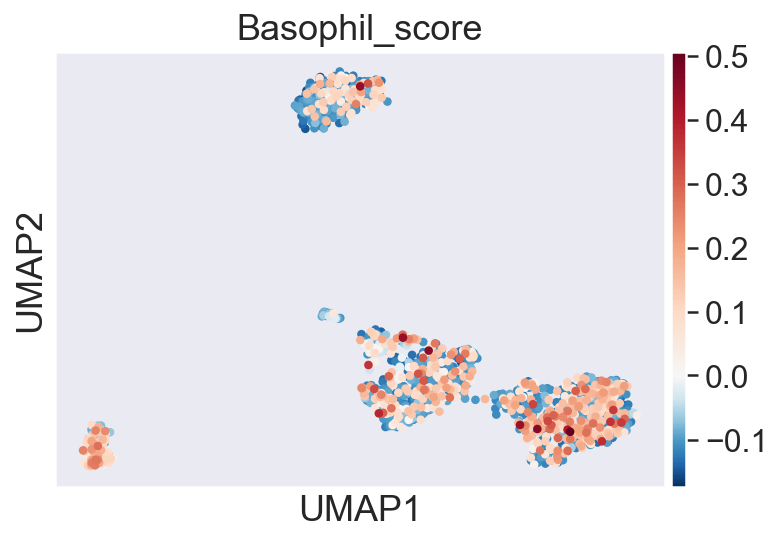

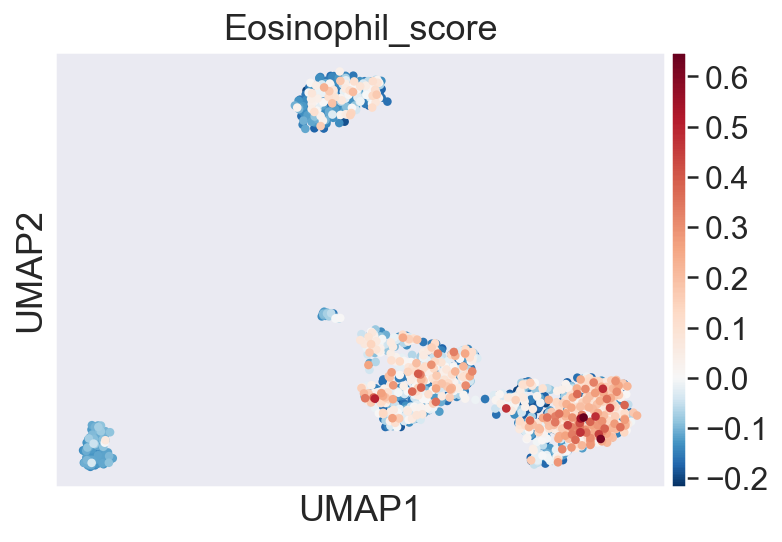

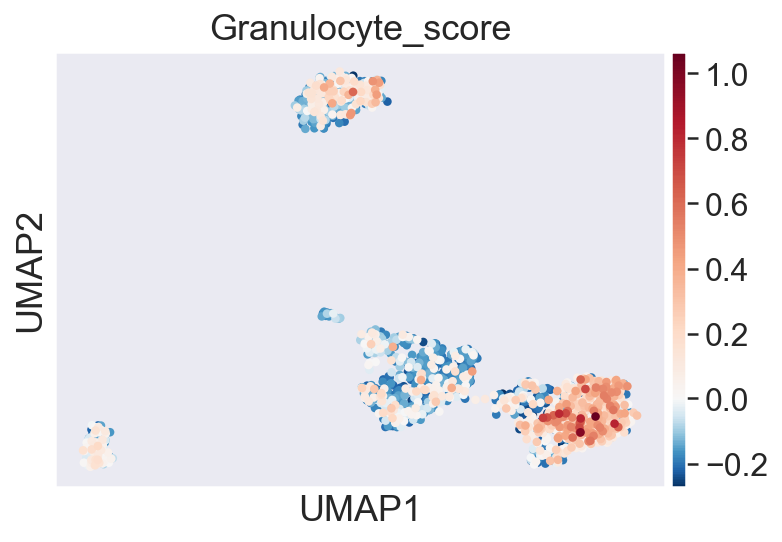

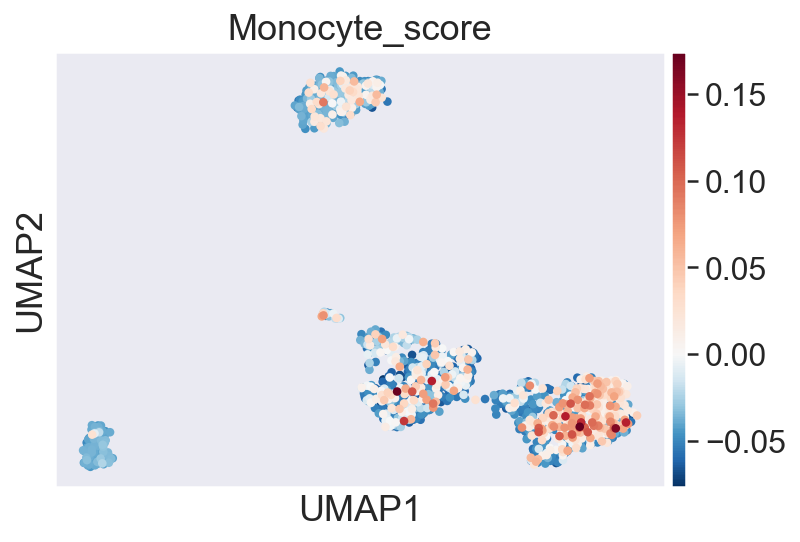

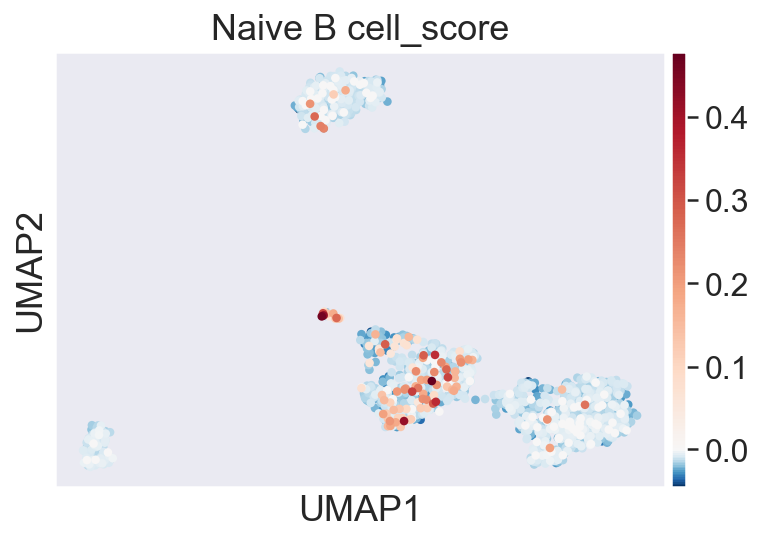

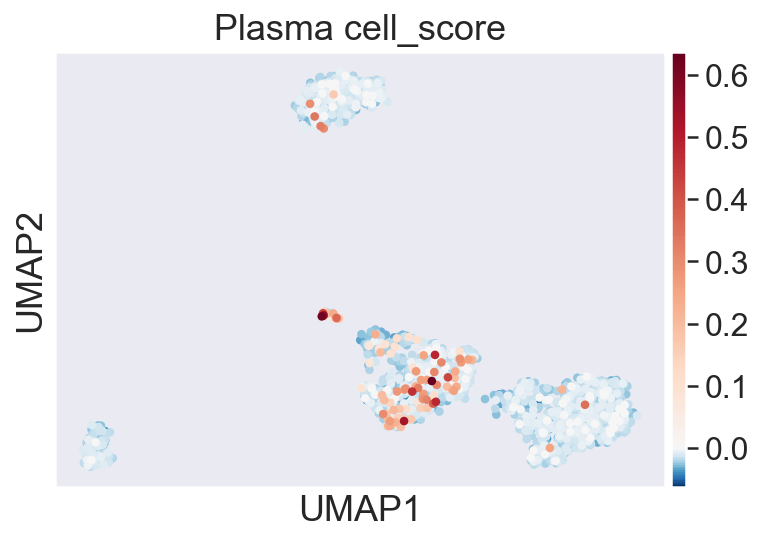

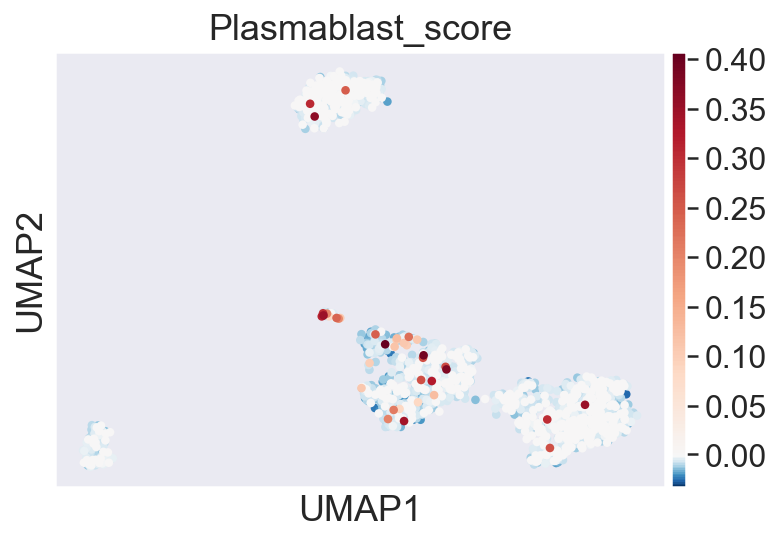

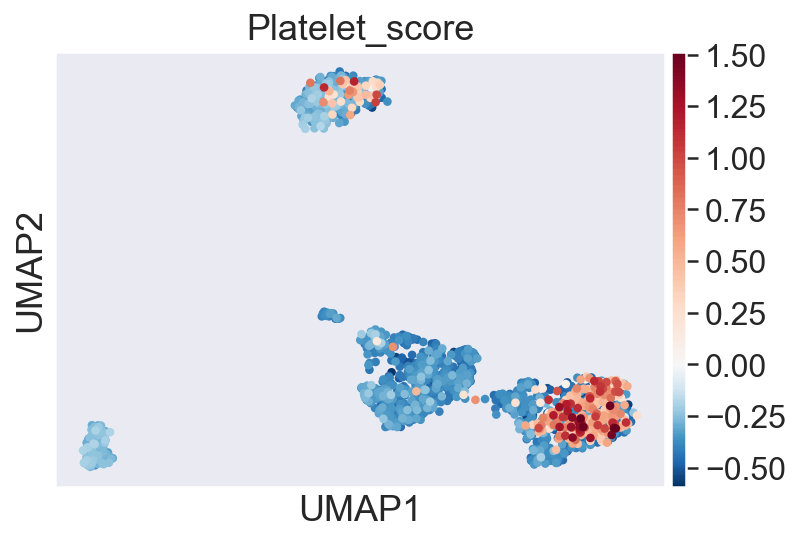

In [15]:
for cell in cell_marker['Cell Type'].unique():
    if cell + '_score' not in l_adata.obs.columns:
        continue
    sc.pl.umap(l_adata, color=cell + '_score', cmap='RdBu_r', vcenter=0)

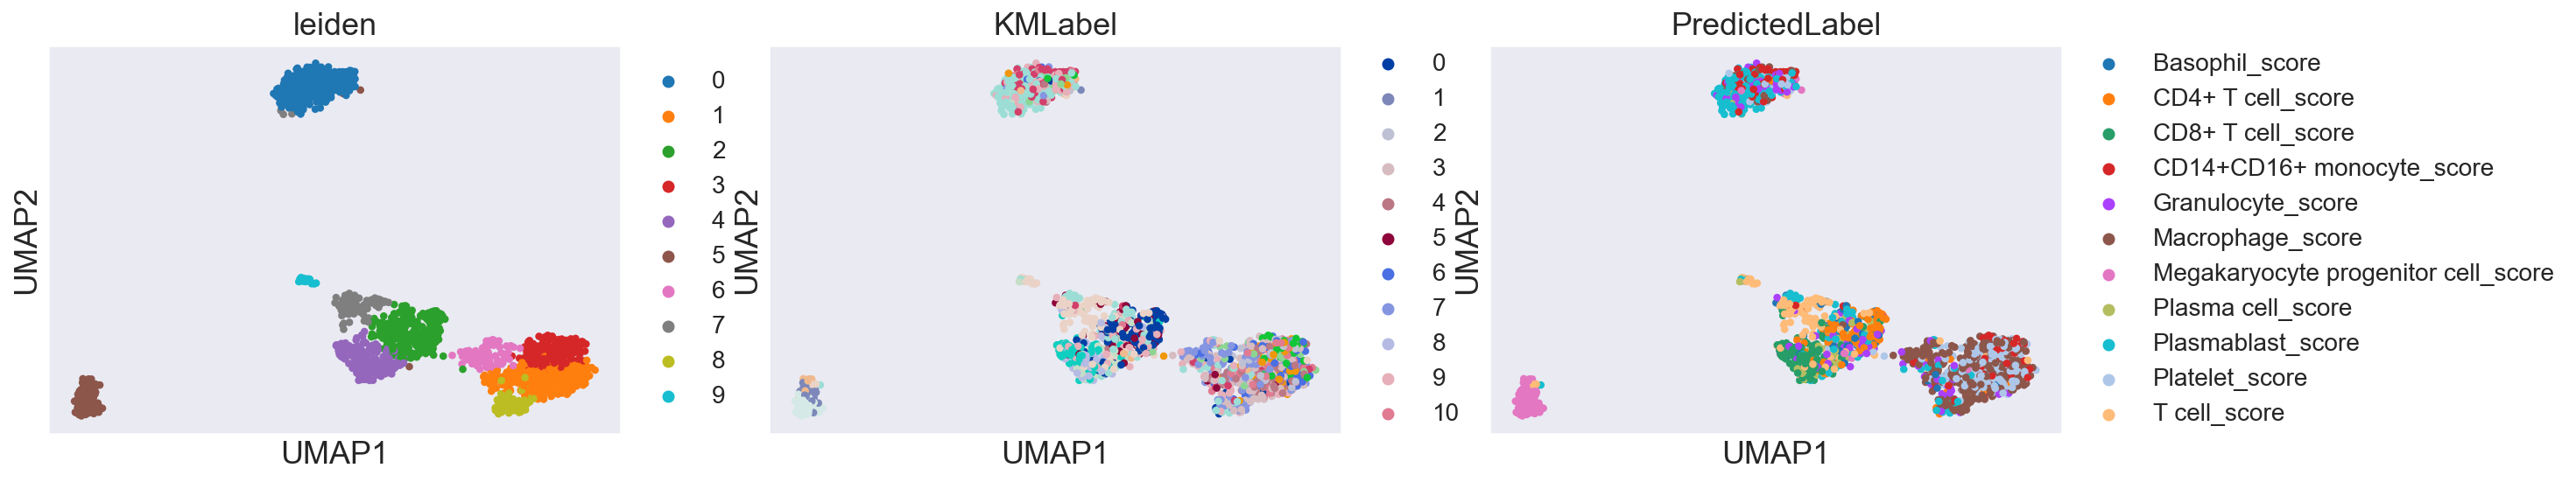

In [16]:
sc.pl.umap(l_adata, color=['leiden', 'KMLabel', 'PredictedLabel'])

In [17]:
adata = h_adata.concatenate(l_adata)

In [18]:
selected = []
for ctype, sub in adata.obs.groupby('PredictedLabel'):
    sampled = sub.sample(n=np.min([100, sub.shape[0]]))
    selected += sampled.index.tolist()

balanced = adata[selected]
sc.tl.pca(balanced, svd_solver='arpack')
sc.pp.neighbors(balanced, n_neighbors=40, n_pcs=50)
sc.tl.leiden(balanced, resolution=1)
sc.tl.umap(balanced)#, init_pos='paga')

... storing 'PredictedLabel' as categorical


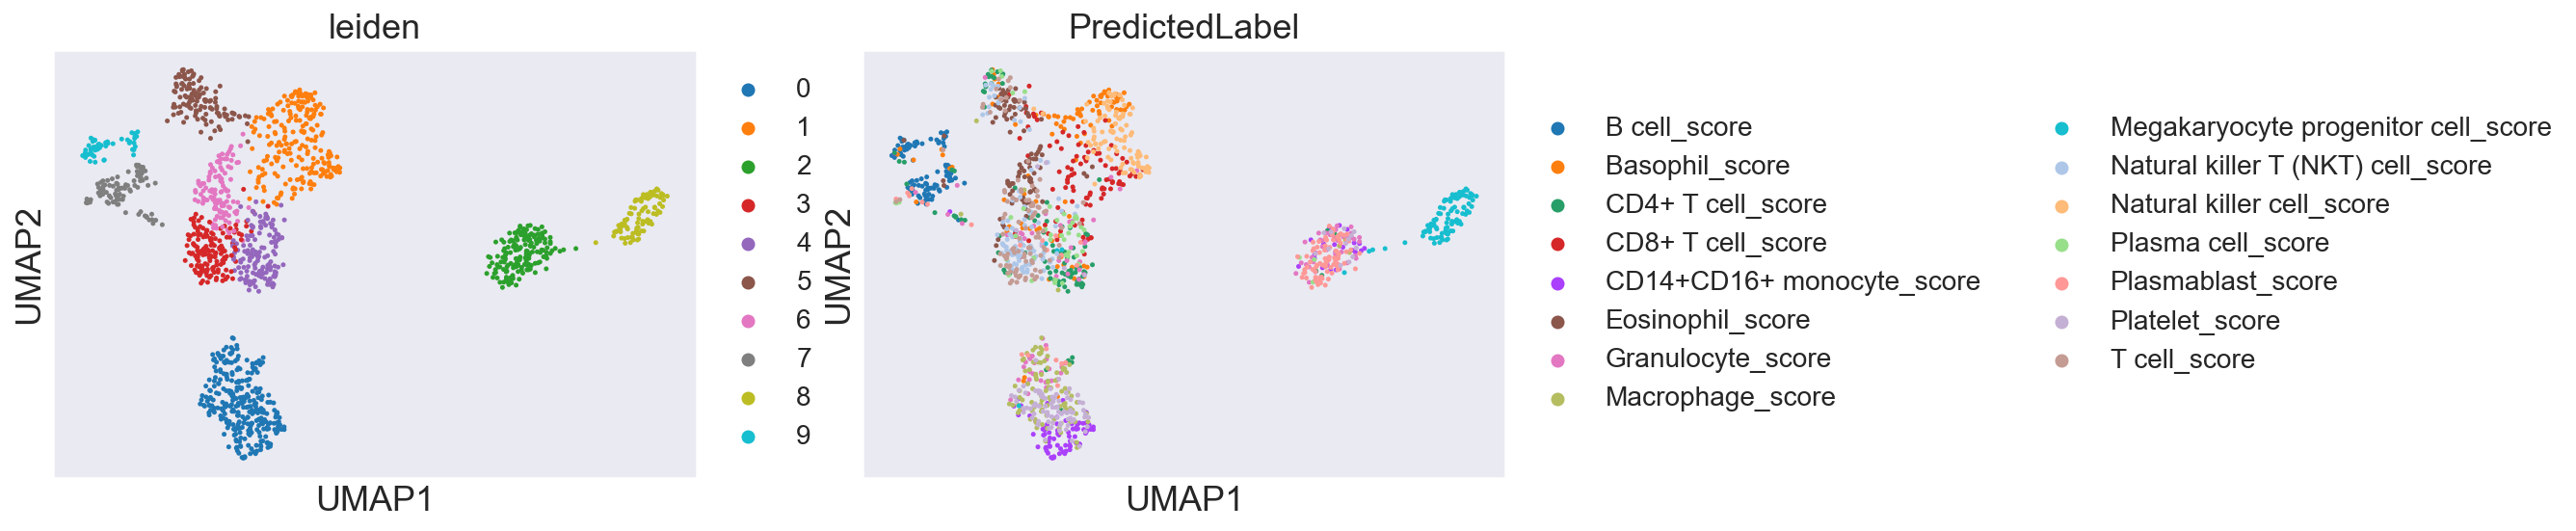

In [19]:
sc.pl.umap(balanced, color=['leiden', 'PredictedLabel'], s=25)

... storing 'PredictedLabel' as categorical
... storing 'leiden' as categorical


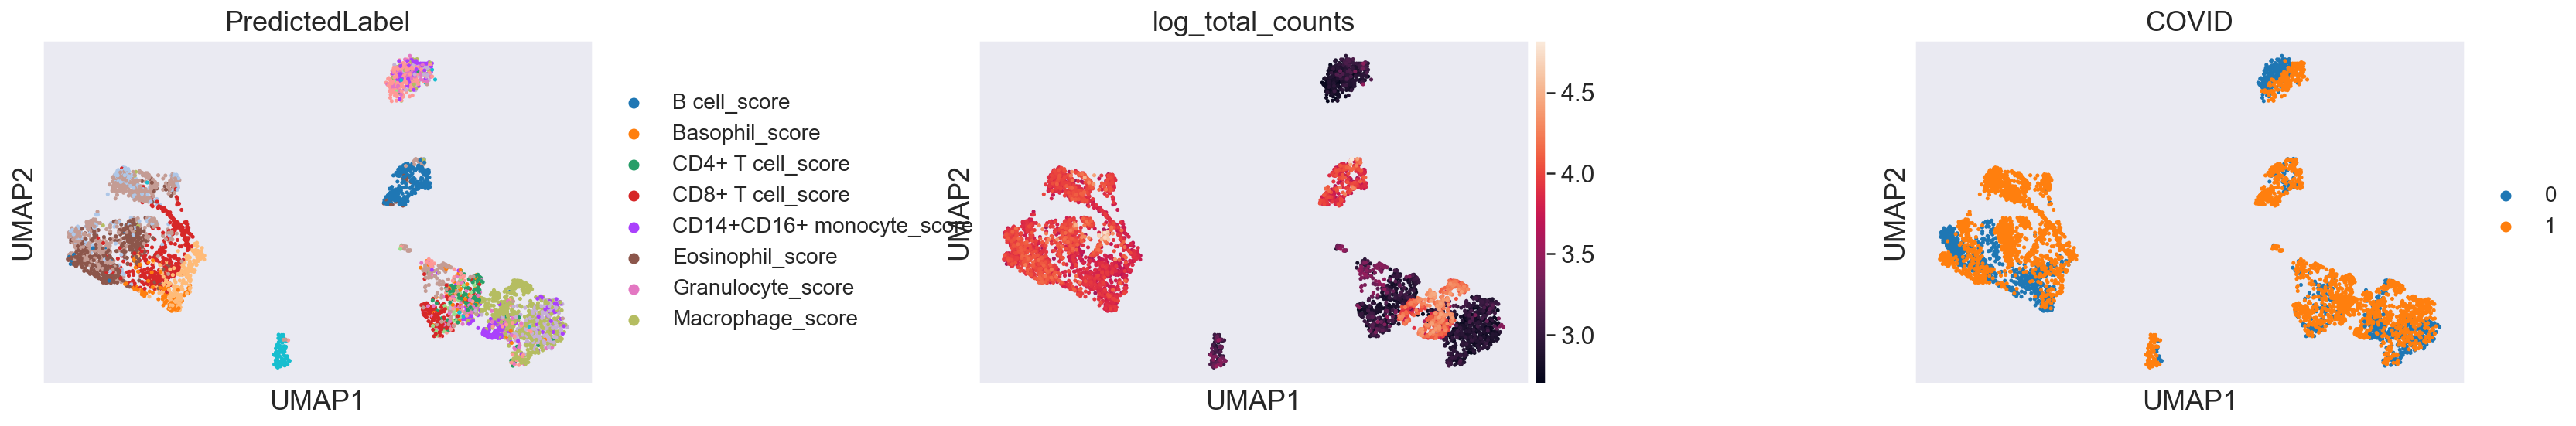

In [20]:
adata.obs.COVID = adata.obs.COVID.astype('category')
sc.pl.umap(adata, color=['PredictedLabel', 'log_total_counts', 'COVID'], wspace=.55)

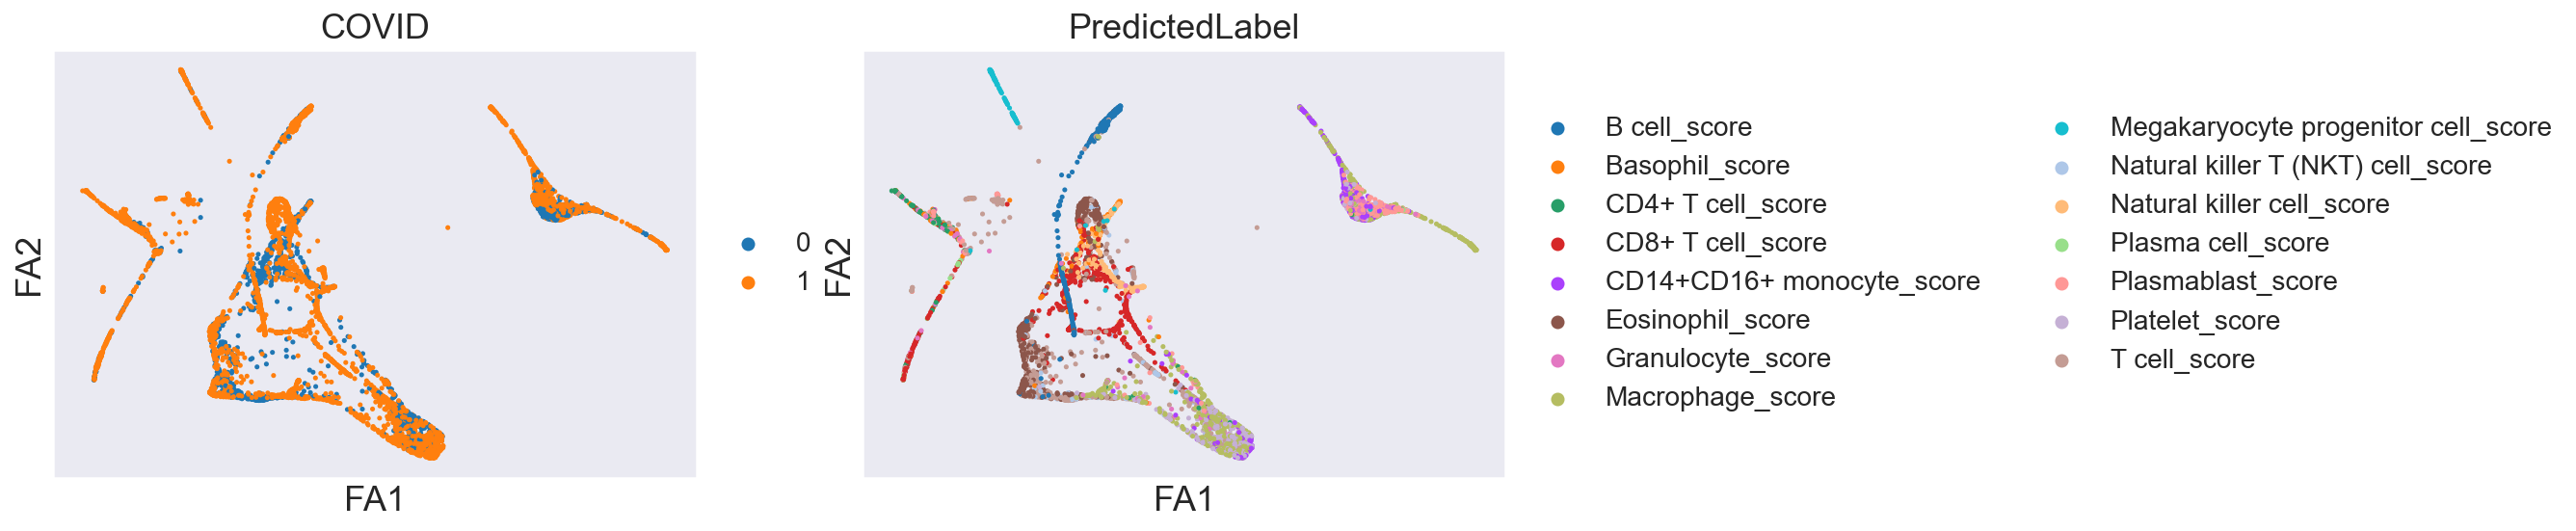

In [22]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.tl.paga(adata)
sc.pl.draw_graph(adata, color=['COVID', 'PredictedLabel'])

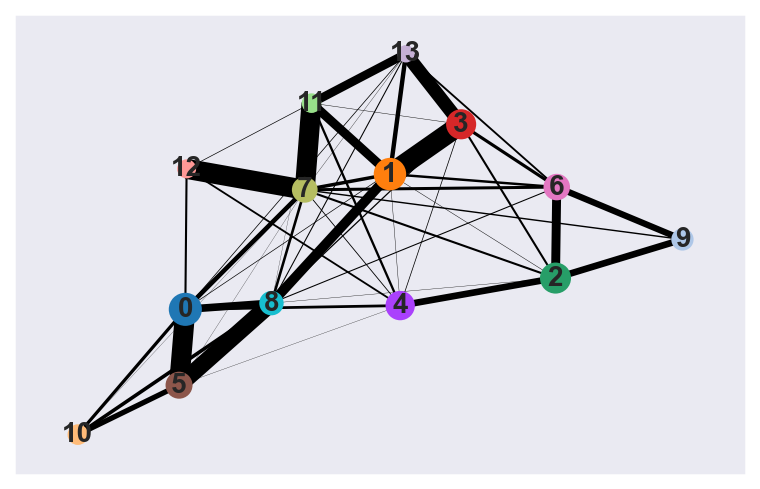

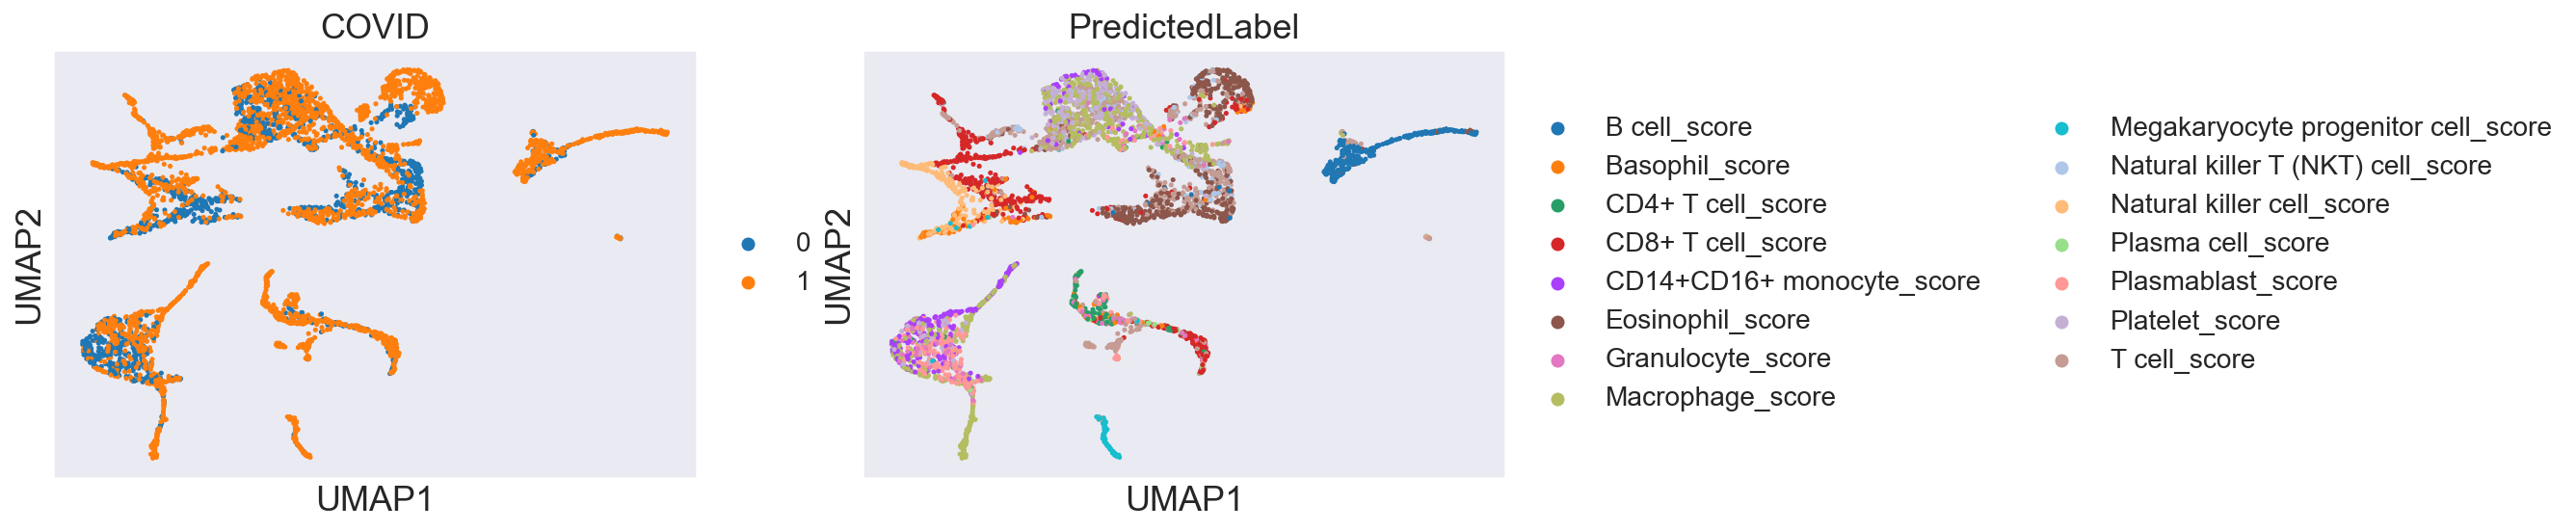

In [23]:
sc.pl.paga(adata)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['COVID', 'PredictedLabel'])

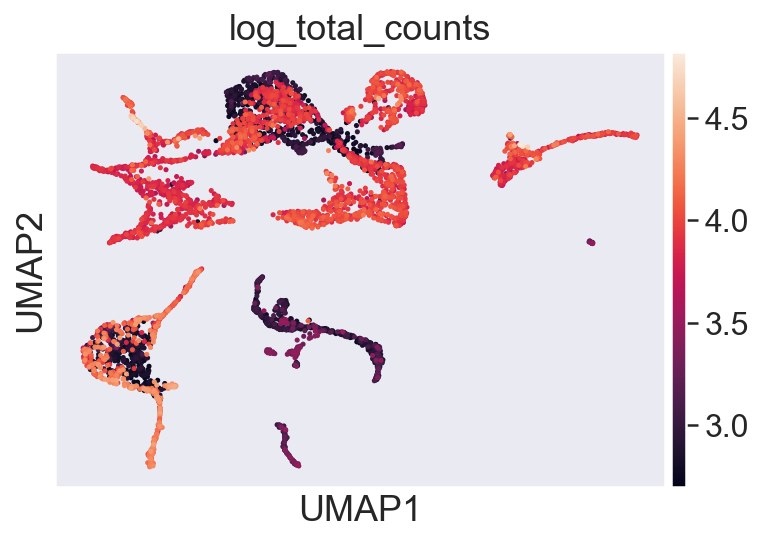

In [24]:
sc.pl.umap(adata, color=['log_total_counts'])

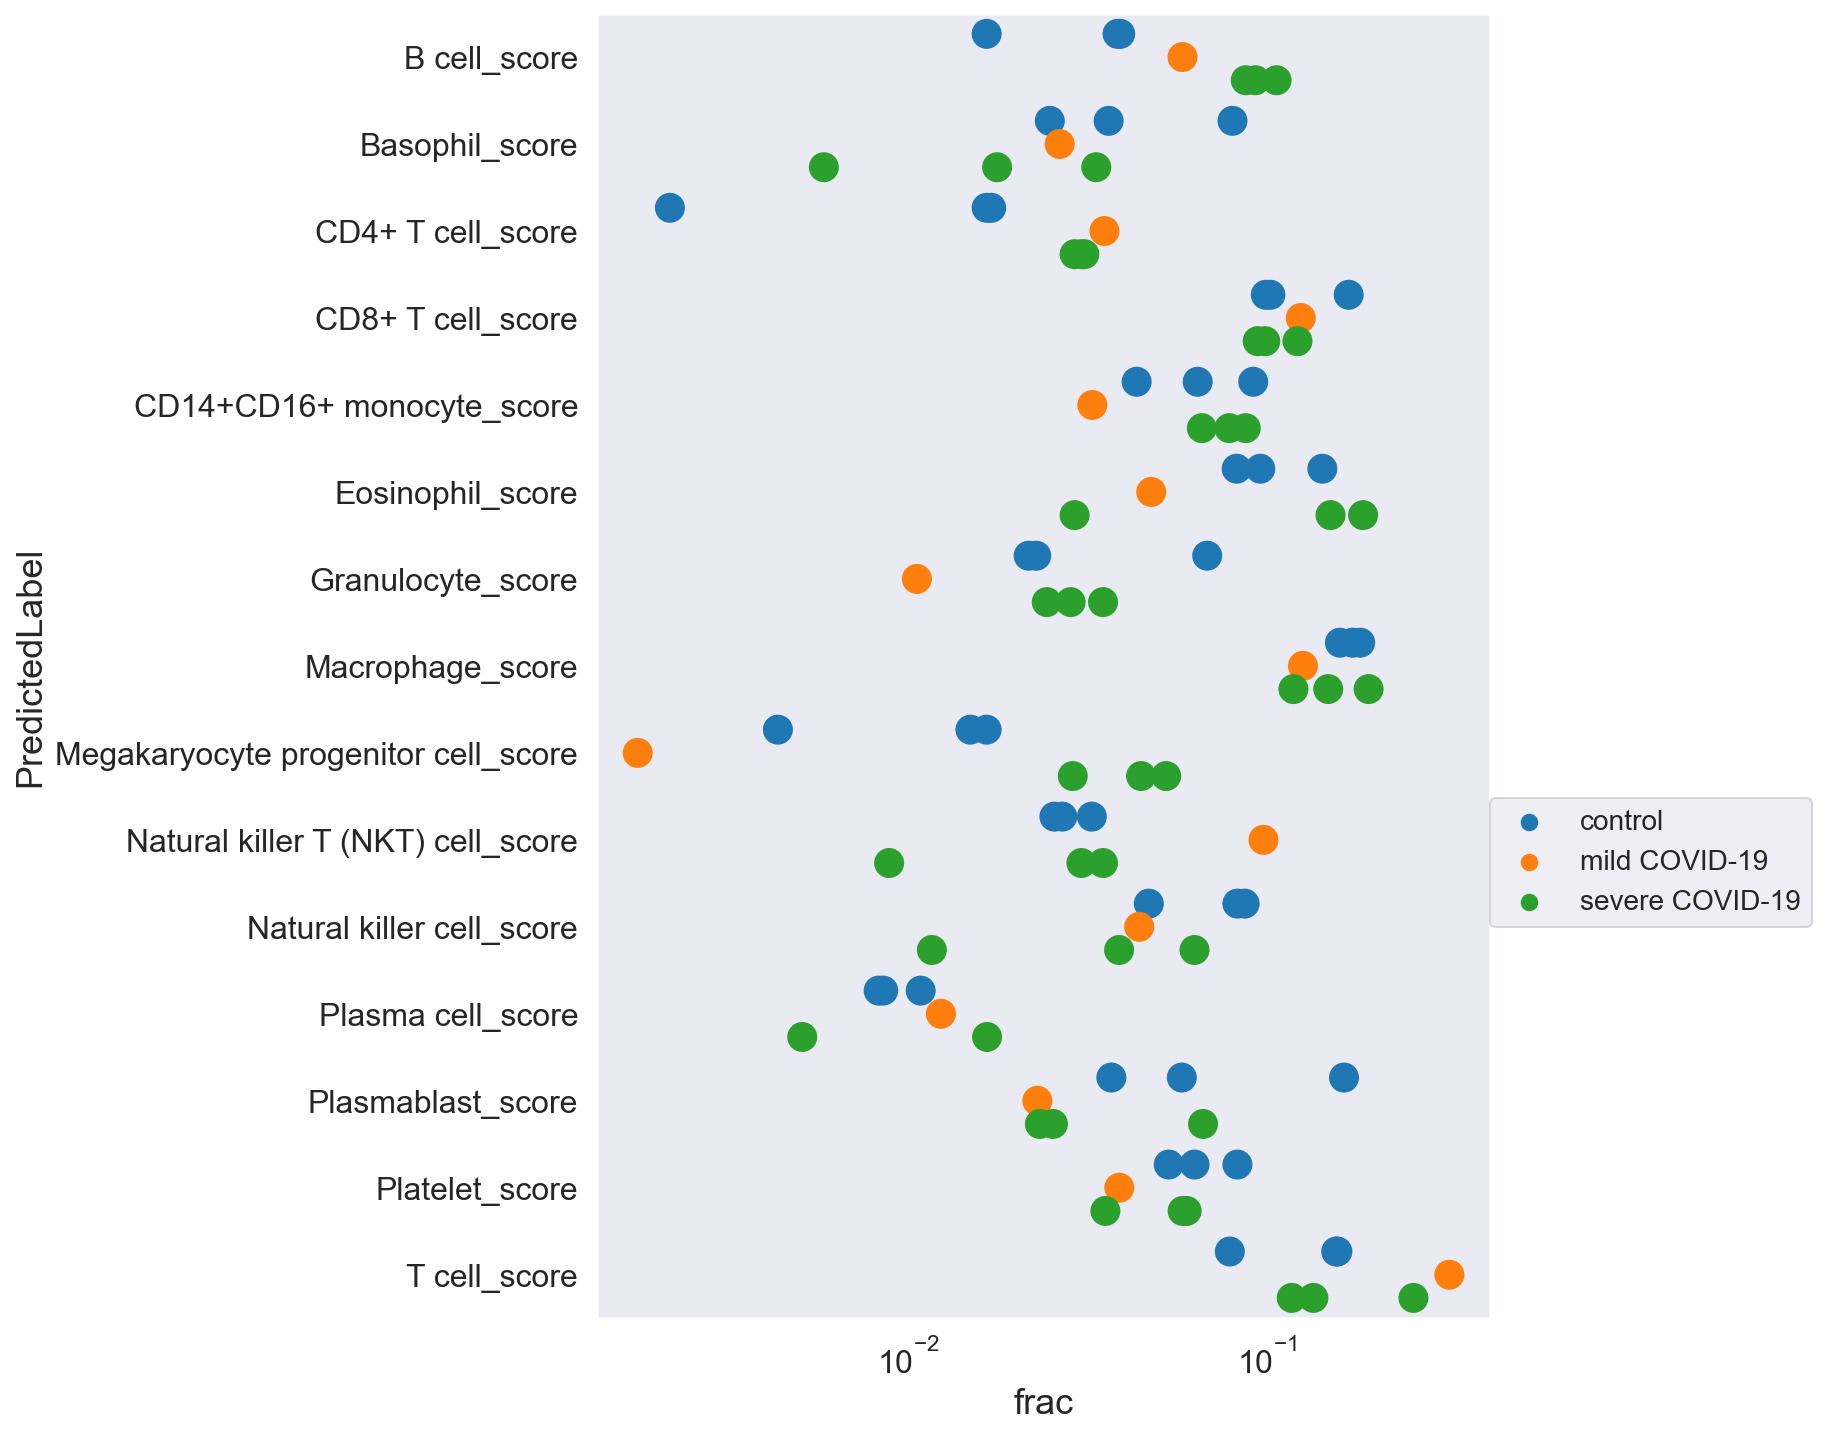

In [25]:
cell_types = adata.obs.groupby(['Sample Characteristic[individual]',
                                'PredictedLabel',
                                'Sample Characteristic[clinical history]']).total_counts.count().reset_index()

cell_types['total_cells'] = cell_types.groupby('Sample Characteristic[individual]').total_counts.transform(np.sum)
cell_types['frac'] = cell_types.total_counts / cell_types.total_cells
cell_types['mean'] = cell_types.groupby(['PredictedLabel', 'Sample Characteristic[clinical history]']).frac.transform(np.mean)
cell_types.sort_values('mean', inplace=True)

fig, ax = plt.subplots(figsize=(8, 12))
sns.stripplot(y='PredictedLabel', x='frac', hue='Sample Characteristic[clinical history]',
              data=cell_types, jitter=False, s=15, ax=ax, dodge=True)
plt.legend(loc=(1, .3))
plt.xscale('log')